**Group3_GA3_Week5**

### <center>Tripadvisor ISKCON Temple (Bangalore) Review Analysis in Jupyter</center>
<center>Big Data Analytics - Analysis of Text and Social Media Data: Individual Assignment Week-5</center>
<center>ePGD ABA 2020-21</center>

**Group-3 includes : Nitin Raheja, Rohan Singh, Anand Dattani, and Arimitra Maiti**

**CAUTION - This notebook takes roughly 15 minutes to complete execution (excluding model train) \
This notebook may not run end to end in google colab environment or mac environment \
The input file for this notebook comes from the output of the first notebook**

**The target class encoding is as follows : {"NEGATIVE":0, "NEUTRAL":1, "MIXED":2, "POSITIVE":3}**

In [1]:
###Need to use nltk download commands for the first time to set up the machine
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('sentiwordnet')

In [2]:
##Import basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import math
import sys

In [3]:
import string
import re

In [4]:
# !pip install wordcloud
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
# conda config --add channels conda-forge
# conda install pyahocorasick
# !pip install contractions
import contractions

In [7]:
from nltk.corpus import wordnet

In [8]:
# !pip install textblob
from textblob import TextBlob

In [9]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [10]:
# !pip install afinn
from afinn import Afinn

In [11]:
# ##Import review data obtained from tripadvisor crawler
# dataset = pd.read_csv("cleaned_comments.csv", parse_dates=True, usecols=['SOURCE', 'REVIEW DATE', 'REVIEW SUBJECT',
#                                                                         'text', 'REVIEW RATING', 'Target'],
#                       encoding = "ISO-8859-1")
# dataset.head()

In [12]:
#Import review data obtained from tripadvisor crawler
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/articles/cleaned_comments.csv"
dataset = pd.read_csv(url, error_bad_lines = False, header=0, index_col=None, parse_dates=True,
                      usecols=['SOURCE', 'REVIEW DATE', 'REVIEW SUBJECT','text', 'REVIEW RATING', 'Target'],
                      encoding = "ISO-8859-1")
dataset.head(4)

,SOURCE,REVIEW DATE,REVIEW SUBJECT,text,REVIEW RATING,Target
0,Trip Advisor,30-04-2014,To commercial,This reativly new temple was a big hindu versi...,2,NEGATIVE
1,Trip Advisor,24-07-2015,?Amazing temple in Bangalore?,Me and my friends enjoyed a lot in ISKCON temp...,5,POSITIVE
2,Trip Advisor,28-07-2016,A well maintained temple,Otherworldly vibrations throuout the sanctuary...,5,POSITIVE
3,Trip Advisor,23-08-2016,Temple,"ISKCON temple is very good, located in west of...",5,POSITIVE


In [13]:
##Rename columns
dataset.columns = ['source', 'date', 'title', 'review', 'score', 'target']


dataset.date = pd.to_datetime(dataset.date)
##Sort data by date of review
dataset = dataset.sort_values(by=['date'], ascending=True)

In [14]:
dataset.head()

,source,date,title,review,score,target
944,Trip Advisor,2013-01-03,Very neat place to see,"Make the time to see this landmark, it really ...",4,POSITIVE
1188,Trip Advisor,2013-01-05,Very modern,Very modern. all made of marble and very organ...,3,MIXED
2092,Google + HK HILL,2013-01-06,iskcon temple beatiful place,the temple is vry crowded and the food is not ...,3,MIXED
493,Trip Advisor,2013-01-06,VERY PEACEFULL,The Temple is made beautifully and the presenc...,5,POSITIVE
2563,Facebook,2013-01-08,Must see in Bangalore,ISKCON temple is located on top of a hillock c...,5,POSITIVE


In [15]:
dataset.shape

(4641, 6)

In [16]:
##Reset index
dataset = dataset.reset_index(drop="index")

In [17]:
##Check for missing values in the dataset
dataset.isnull().sum()/dataset.shape[0] * 100

source     0.064641
date       0.000000
title     40.400776
review     0.086188
score      0.000000
target     0.000000
dtype: float64

In [18]:
##Replace missing reviews only with titles
dataset.review = np.where(dataset.index.isin(list(dataset[(dataset.review.isnull()==True) & (dataset.title.isnull()==False)].index)),
                         dataset.title, dataset.review)

In [19]:
##Delete rows where both title and reviews are missing as there is no information of customer comments
dataset.drop(dataset[dataset.review.isnull()].index, inplace=True)

In [20]:
dataset.shape

(4639, 6)

In [21]:
##Reset index
dataset = dataset.reset_index(drop="index")

In [22]:
##Check for missing values in the dataset
dataset.isnull().sum()/dataset.shape[0] * 100

source     0.064669
date       0.000000
title     40.375081
review     0.000000
score      0.000000
target     0.000000
dtype: float64

In [23]:
my_stop_list_ = ["bangalore","krishna","iskcon","place","visit","visited","hare","one","also","iskon","etc","can","rama","radha","hindu","idols","sri","god","lord","isckon"]

In [24]:
dataset_processing = dataset.copy()

In [25]:
dataset_processing.shape

(4639, 6)

In [26]:
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import sentiwordnet as swn

In [27]:
def pre_processing(dataset, my_stop_list):
    ##Use contractions
    dataset['review_modified'] = dataset['review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
    ##convert list to string
    dataset['review_modified_unlist'] = [' '.join(map(str, l)) for l in dataset['review_modified']]
    ##convert string to tokens
    dataset['review_mod_tokens'] = dataset['review_modified_unlist'].apply(nltk.word_tokenize)
    ##convert token to lower case
    dataset['review_mod_tokens'] = dataset['review_mod_tokens'].apply(lambda x: [word.lower() for word in x])
    ##remove punctuations
    dataset['review_mod_tokens'] = dataset['review_mod_tokens'].apply(lambda x: [word for word in x if word not in string.punctuation])
    stop_set = set(nltk.corpus.stopwords.words('english'))
    stop_set.update(my_stop_list)
    ##remove default and custom stop words
    dataset['review_mod_tokens'] = dataset['review_mod_tokens'].apply(lambda x: [word for word in x if word not in stop_set])
    ##extract parts of speech tags
    dataset['review_tags'] = dataset['review_mod_tokens'].apply(nltk.tag.pos_tag)
    
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    dataset['review_wordnet'] = dataset['review_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    ##use lemmatizer on parts of speech tags
    lm = WordNetLemmatizer()
    dataset['review_lemmatized'] = dataset['review_wordnet'].apply(lambda x: [lm.lemmatize(word, tag) for word, tag in x])
    
    dataset['review_str'] = [' '.join(map(str,l)) for l in dataset['review_lemmatized']]
    ##extract sentiment score from parts of speech tags
    dataset['sentiment_score_textblob'] = dataset['review_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    def afinn_polarity(text):
        return Afinn().score(text)
    
    def score_sentiwordnet(doc):
        synsets = (wordnet.synsets(w) for w in nltk.word_tokenize(doc) if w is not None) # tokenize and lookup synonyms in WordNet
        words = (s[0].name() for s in synsets if s is not None and len(s) > 0) # use the first (most common) synonym
        words = (swn.senti_synset(s) for s in words) # get sentiment scores which have pos, neg, and neutral parts
        scores = ((1 - w.obj_score()) * (w.pos_score() - w.neg_score()) for w in words) # calculate individual word scores
        return (sum(scores)) # classify document as positive if resulting score is positive
    
    def ifformula(score):
        if score < 0:
            return "0"
        elif score == 0:
            return "1"
        else:
            return "2"
    
    dataset['sentiment_score_afinn'] = dataset['review_str'].apply(afinn_polarity)
    dataset['sentiment_score_sentinet'] = dataset['review_str'].apply(score_sentiwordnet)
    
    dataset['sentiment_score_afinn'] = dataset['sentiment_score_afinn'].apply(ifformula)
    dataset['sentiment_score_textblob'] = dataset['sentiment_score_textblob'].apply(ifformula)
    dataset['sentiment_score_sentinet'] = dataset['sentiment_score_sentinet'].apply(ifformula)
    
    dataset = dataset[['score', 'date', 'title', 'target', 'review_lemmatized', 'review',
                       'review_str', 'sentiment_score_textblob', 'sentiment_score_sentinet', 'sentiment_score_afinn']]

    return dataset

In [28]:
dataset_processing = pre_processing(dataset_processing, my_stop_list_)

In [29]:
dataset_processing['word_count'] = dataset_processing['review_lemmatized'].apply(lambda x: len(str(x).split()))
dataset_processing['review_length'] = dataset_processing['review_str'].astype(str).apply(len)

In [30]:
dataset_processing.shape

(4639, 12)

In [31]:
# dataset_processing.to_csv("dataset_processing.csv")

In [32]:
##Process to extract LDA topics
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(dataset_processing['review_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))

lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
good food restaurant prasadam day spend serve high time prasad
Topic 1:
temple main take get inside go shop people book many
Topic 2:
temple like must experience go love really great feel see
Topic 3:
peace mind atmosphere chant feel temple good time best get
Topic 4:
temple well nice good clean maintain beautiful peaceful must city


In [33]:
lda_topic_values = lda_model.transform(tf)
dataset_processing['lda_topic_id'] = lda_topic_values.argmax(axis=1)

In [34]:
##Map bubble rating score to 3 classes, 1 having score 10 & 20, 2 having score 30, 3 having score of 40 & 50 
score_mapping = {"NEGATIVE":0, "NEUTRAL":1, "MIXED":2, "POSITIVE":3}
dataset_processing["target"] = dataset_processing.target.map(score_mapping)

dataset_processing.target.value_counts().sort_index()
# dataset['Name'].unique()

0     270
1      92
2     277
3    4000
Name: target, dtype: int64

In [35]:
dataset_processing.columns

Index(['score', 'date', 'title', 'target', 'review_lemmatized', 'review',
       'review_str', 'sentiment_score_textblob', 'sentiment_score_sentinet',
       'sentiment_score_afinn', 'word_count', 'review_length', 'lda_topic_id'],
      dtype='object')

In [36]:
##Extract month and year and store as categories
dataset_processing['text_year'] = pd.DatetimeIndex(dataset_processing['date']).year
dataset_processing['text_month'] = pd.DatetimeIndex(dataset_processing['date']).month

dataset_processing['text_year'] = dataset_processing['text_year'].astype('O')
dataset_processing['text_month'] = dataset_processing['text_month'].astype('O')

In [37]:
###Consider sentiment scores as features derived from sentiment score binning and actual trip advisor scores
##The target column remains untouched to avoid multicollinearity
c1 = dataset_processing['sentiment_score_textblob'] == "0"
c2 = dataset_processing['sentiment_score_sentinet'] == "0"
c3 = dataset_processing['sentiment_score_afinn'] == "0"
c4 = dataset_processing['score'] == 1
c5 = dataset_processing['score'] == 2

dataset_processing['neg_class'] = np.logical_or.reduce((c1, c2, c3, c4, c5))

c1 = dataset_processing['sentiment_score_textblob'] == "2"
c2 = dataset_processing['sentiment_score_sentinet'] == "2"
c3 = dataset_processing['sentiment_score_afinn'] == "2"
c4 = dataset_processing['score'] == 4
c5 = dataset_processing['score'] == 5

dataset_processing['pos_class'] = np.logical_and.reduce((c1, c2, c3, np.logical_or.reduce((c4, c5))))

c1 = dataset_processing['neg_class'] == False
c2 = dataset_processing['pos_class'] == False

dataset_processing['neu_class'] = np.logical_and.reduce((c1, c2))

del c1, c2, c3, c4, c5

def bool_cat(score):
    if score == True:
        return "1"
    else:
        return "0"

dataset_processing['neg_class'] = dataset_processing['neg_class'].apply(bool_cat)
dataset_processing['pos_class'] = dataset_processing['pos_class'].apply(bool_cat)
dataset_processing['neu_class'] = dataset_processing['neu_class'].apply(bool_cat)

In [38]:
dataset_processing = dataset_processing[['target', 'word_count', 'lda_topic_id', 'pos_class', 'neg_class', 'neu_class', 'review_str', 'text_year', 'text_month']]

In [39]:
dataset_processing.shape

(4639, 9)

In [40]:
# !python -m pip install -U gensim

In [41]:
###First time download may take upto 30 minutes
##Download google word2vec pre trained model from gensim
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [42]:
##Create unique set of words from google model
vocabulary = set(wv.index2word)

In [43]:
##Dimension of each word
embedding_size = wv.vector_size

In [44]:
print("Model contains %d words" %len(vocabulary))

Model contains 3000000 words


In [45]:
print("Each word is represented by a %d dimensional vector" %embedding_size)

Each word is represented by a 300 dimensional vector


In [46]:
##Create X and y attrs, X here has only one column from the explicit dataset
##We are yet to form the features
X, y = dataset_processing['review_str'], dataset_processing[['target']]
X.shape, y.shape

((4639,), (4639, 1))

In [47]:
##Define word2vec function where mean of the vectors would be considered if the word exists Else zero
def mean_vector(review):
    zero = np.zeros((embedding_size,), dtype="float32")
    if pd.isnull(review):
        return zero
    words = [w for w in review.split() if w in vocabulary]
    if not words:
        return zero
    return np.mean([wv[w] for w in words], axis=0)

In [48]:
cols = ['v_'+str(i) for i in range(embedding_size)]

In [49]:
dfV = pd.DataFrame(list(map(mean_vector, X)), columns=cols)

In [50]:
X, y = dfV, y
X.shape, y.shape

((4639, 300), (4639, 1))

In [51]:
add_features = dataset_processing[['word_count', 'lda_topic_id', 'pos_class', 'neg_class', 'neu_class', 'text_year', 'text_month']]

In [52]:
X_new = pd.concat([add_features, X], axis=1)
X_new.shape, y.shape

((4639, 307), (4639, 1))

In [53]:
X_new['lda_topic_id'] = X_new['lda_topic_id'].astype('O')

In [54]:
# !pip install scikit-multilearn

import skmultilearn
from skmultilearn.model_selection import iterative_train_test_split

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
print(f"Proportion for Target class:0 is {round((np.unique(y, return_counts=True)[1][0]/y.shape[0])*100,2)} percent in parent set")
print(f"Proportion for Target class:1 is {round((np.unique(y, return_counts=True)[1][1]/y.shape[0])*100,2)} percent in parent set")
print(f"Proportion for Target class:2 is {round((np.unique(y, return_counts=True)[1][2]/y.shape[0])*100,2)} percent in parent set")
print(f"Proportion for Target class:3 is {round((np.unique(y, return_counts=True)[1][3]/y.shape[0])*100,2)} percent in parent set")

Proportion for Target class:0 is 5.82 percent in parent set
Proportion for Target class:1 is 1.98 percent in parent set
Proportion for Target class:2 is 5.97 percent in parent set
Proportion for Target class:3 is 86.23 percent in parent set


In [57]:
del X

In [58]:
X = X_new.copy()

In [59]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

X_data.shape, X_test.shape, y_data.shape, y_test.shape

((3711, 307), (928, 307), (3711, 1), (928, 1))

In [60]:
##Further Divide total rows of the 80 above, into 80:20 and keep the 20 for validation
X = X_data.copy()
y = y_data.copy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((2968, 307), (743, 307), (2968, 1), (743, 1))

In [61]:
X_data.shape, X_test.shape

((3711, 307), (928, 307))

In [62]:
print(f"Proportion for Target class:0 is {round((np.unique(y_train, return_counts=True)[1][0]/y_train.shape[0])*100,2)} percent in train set")
print(f"Proportion for Target class:1 is {round((np.unique(y_train, return_counts=True)[1][1]/y_train.shape[0])*100,2)} percent in train set")
print(f"Proportion for Target class:2 is {round((np.unique(y_train, return_counts=True)[1][2]/y_train.shape[0])*100,2)} percent in train set")
print(f"Proportion for Target class:3 is {round((np.unique(y_train, return_counts=True)[1][3]/y_train.shape[0])*100,2)} percent in train set")

Proportion for Target class:0 is 5.83 percent in train set
Proportion for Target class:1 is 1.99 percent in train set
Proportion for Target class:2 is 5.96 percent in train set
Proportion for Target class:3 is 86.22 percent in train set


In [63]:
print(f"Proportion for Target class:0 is {round((np.unique(y_valid, return_counts=True)[1][0]/y_valid.shape[0])*100,2)} percent in validation set")
print(f"Proportion for Target class:1 is {round((np.unique(y_valid, return_counts=True)[1][1]/y_valid.shape[0])*100,2)} percent in validation set")
print(f"Proportion for Target class:2 is {round((np.unique(y_valid, return_counts=True)[1][2]/y_valid.shape[0])*100,2)} percent in validation set")
print(f"Proportion for Target class:3 is {round((np.unique(y_valid, return_counts=True)[1][3]/y_valid.shape[0])*100,2)} percent in validation set")

Proportion for Target class:0 is 5.79 percent in validation set
Proportion for Target class:1 is 2.02 percent in validation set
Proportion for Target class:2 is 5.92 percent in validation set
Proportion for Target class:3 is 86.27 percent in validation set


In [64]:
print(f"Proportion for Target class:0 is {round((np.unique(y_test, return_counts=True)[1][0]/y_test.shape[0])*100,2)} percent in test set")
print(f"Proportion for Target class:1 is {round((np.unique(y_test, return_counts=True)[1][1]/y_test.shape[0])*100,2)} percent in test set")
print(f"Proportion for Target class:2 is {round((np.unique(y_test, return_counts=True)[1][2]/y_test.shape[0])*100,2)} percent in test set")
print(f"Proportion for Target class:3 is {round((np.unique(y_test, return_counts=True)[1][3]/y_test.shape[0])*100,2)} percent in test set")

Proportion for Target class:0 is 5.82 percent in test set
Proportion for Target class:1 is 1.94 percent in test set
Proportion for Target class:2 is 6.03 percent in test set
Proportion for Target class:3 is 86.21 percent in test set


In [65]:
##check if any numerical features have any constant variance, i.e. standard deviation as zero
store = []
for i in range(len(X_train.columns)):
    if X_train[X_train.columns[i]].dtype != 'object':
        varname = X_train.columns[i]
        store.append(varname)

constant_features = [x for x in store if X_train[x].std() == 0]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_valid.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

print(X_train.shape, X_valid.shape, X_test.shape)

(2968, 307) (743, 307) (928, 307)


In [66]:
del store

In [67]:
# create an empty list
quasi_constant_feat = []

# iterate over every attributes in the train set including numerical and object variables
for k in X_train.columns:
    # find the dominant value, that is the value that is shared by most observations
    predominant = (X_train[k].value_counts() / np.float(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the dominant feature: do more than 99% of the observations show 1 single value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(k)

len(quasi_constant_feat)

0

In [68]:
quasi_constant_feat

[]

In [69]:
X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_valid.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

print(X_train.shape, X_valid.shape, X_test.shape)

(2968, 307) (743, 307) (928, 307)


In [70]:
##Check if we have features that despite having different names, are identical.
# check for duplicated features in the training set:

# create an empty dictionary, where we will store 
# the groups of duplicates
duplicated_feat_pairs = {}

# create an empty list to collect features
# that were found to be duplicated
_duplicated_feat = []


# iterate over every feature in our dataset:
for i in range(0, len(X_train.columns)):
    
    # this bit helps me understand where the loop is at:
    if i % 10 == 0:  
        print(i)
    
    # choose 1 feature:
    feat_1 = X_train.columns[i]
    
    # check if this feature has already been identified
    # as a duplicate of another one. If it was, it should be stored in
    # our _duplicated_feat list.
    
    # If this feature was already identified as a duplicate, we skip it, if
    # it has not yet been identified as a duplicate, then we proceed:
    if feat_1 not in _duplicated_feat:
    
        # create an empty list as an entry for this feature in the dictionary:
        duplicated_feat_pairs[feat_1] = []

        # now, iterate over the remaining features of the dataset:
        for feat_2 in X_train.columns[i + 1:]:

            # check if this second feature is identical to the first one
            if X_train[feat_1].equals(X_train[feat_2]):

                # if it is identical, append it to the list in the dictionary
                duplicated_feat_pairs[feat_1].append(feat_2)
                
                # and append it to our monitor list for duplicated variables
                _duplicated_feat.append(feat_2)
                
                # done!

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300


In [71]:
## If length is positive then we do have some duplicated features
len(_duplicated_feat)
# duplicated_feat_pairs

0

In [72]:
import xgboost as xgb
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, f1_score

In [73]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingClassifier

In [74]:
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder

In [75]:
rare_label_encoder = RareLabelCategoricalEncoder(tol=0.03, n_categories=2,
                                                 variables=['lda_topic_id', 'pos_class', 'neg_class', 'neu_class', 'text_year', 'text_month'])

In [76]:
rare_label_encoder.fit(X_train)
X_train_rlc = rare_label_encoder.transform(X_train)
X_valid_rlc = rare_label_encoder.transform(X_valid)
X_test_rlc = rare_label_encoder.transform(X_test)

In [77]:
ordered_label_encoder = OrdinalCategoricalEncoder(
    encoding_method='ordered',
    variables=['lda_topic_id', 'pos_class', 'neg_class', 'neu_class', 'text_year', 'text_month'])

In [78]:
##Fit the transformer in trainset for both predictors and target labels, this is outside the above pipeline
ordered_label_encoder.fit(X_train_rlc, y_train)

OrdinalCategoricalEncoder(variables=['lda_topic_id', 'pos_class', 'neg_class',
                                     'neu_class', 'text_year', 'text_month'])

In [79]:
##Fit the transformer to train, validation and test sets
X_train1 = ordered_label_encoder.transform(X_train_rlc)
X_valid1 = ordered_label_encoder.transform(X_valid_rlc)
X_test1 = ordered_label_encoder.transform(X_test_rlc)

In [80]:
del X_train, X_valid, X_test

In [81]:
X_train = X_train1.copy()
X_valid = X_valid1.copy()
X_test = X_test1.copy()

In [82]:
X_train.shape, X_valid.shape, X_test.shape

((2968, 307), (743, 307), (928, 307))

In [83]:
# ###RFECV using Light GBM
# sel_ = RFECV(LGBMClassifier(boosting_type ="gbdt", objective = "multiclass", 
#                             n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2, 
#                             reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40, random_state=10, class_weight='balanced'
#                    ),
#              min_features_to_select=10, step=5, scoring="f1_micro")

# sel_.fit(X_train, y_train.values.flatten())

# selected_attr_m2 = X_train.columns[(sel_.get_support())]
# len(selected_attr_m2)

In [84]:
sel_list = ['v_0','v_1','v_2','v_3','v_4','v_5','v_6','v_7','v_8','v_9','v_10','v_11','v_12','v_13','v_14','v_15','v_16','v_17','v_18','v_19','v_20','v_21','v_22','v_23','v_24','v_25','v_26','v_27','v_28','v_29','v_30','v_31','v_32','v_33','v_34','v_35','v_36','v_37','v_38','v_39','v_40','v_41','v_43','v_44','v_45','v_46','v_47','v_48','v_49','v_51','v_52','v_53','v_54','v_55','v_56','v_57','v_58','v_59','v_60','v_61','v_62','v_63','v_64','v_65','v_66','v_67','v_68','v_69','v_70','v_71','v_72','v_73','v_74','v_75','v_76','v_77','v_78','v_79','v_80','v_82','v_83','v_84','v_85','v_86','v_87','v_88','v_89','v_90','v_91','v_92','v_93','v_94','v_95','v_96','v_97','v_98','v_99','v_100','v_101','v_102','v_103','v_104','v_105','v_107','v_108','v_110','v_112','v_113','v_114','v_116','v_117','v_118','v_119','v_121','v_122','v_123','v_124','v_125','v_126','v_127','v_128','v_129','v_130','v_131','v_132','v_133','v_134','v_135','v_136','v_137','v_138','v_139','v_140','v_141','v_142','v_143','v_144','v_145','v_147','v_148','v_150','v_151','v_152','v_153','v_154','v_155','v_156','v_157','v_158','v_159','v_160','v_161','v_162','v_163','v_165','v_166','v_167','v_168','v_169','v_170','v_171','v_172','v_173','v_174','v_176','v_177','v_178','v_179','v_180','v_181','v_182','v_183','v_184','v_185','v_186','v_187','v_188','v_189','v_190','v_191','v_192','v_193','v_194','v_195','v_196','v_197','v_198','v_199','v_200','v_201','v_202','v_203','v_204','v_205','v_206','v_207','v_208','v_209','v_210','v_211','v_212','v_213','v_214','v_215','v_216','v_218','v_219','v_220','v_221','v_222','v_223','v_224','v_225','v_226','v_227','v_228','v_229','v_230','v_231','v_232','v_233','v_234','v_235','v_236','v_237','v_238','v_239','v_240','v_241','v_242','v_243','v_244','v_245','v_246','v_247','v_248','v_249','v_250','v_251','v_252','v_253','v_254','v_255','v_256','v_257','v_258','v_260','v_261','v_262','v_263','v_264','v_265','v_266','v_267','v_268','v_269','v_270','v_271','v_272','v_273','v_274','v_275','v_276','v_277','v_278','v_279','v_281','v_282','v_283','v_284','v_285','v_286','v_287','v_288','v_289','v_290','v_291','v_292','v_293','v_294','v_295','v_296','v_297','v_298','v_299', 'word_count', 'lda_topic_id', 'pos_class', 'neg_class', 'neu_class', 'text_year', 'text_month'
]

In [85]:
X_train_ = X_train[sel_list]
X_valid_ = X_valid[sel_list]
X_test_ = X_test[sel_list]

print(X_train_.shape, X_valid_.shape, X_test_.shape)

(2968, 292) (743, 292) (928, 292)


In [86]:
##Import scaling module
from sklearn.preprocessing import MinMaxScaler

##Train the scaler in trainset
sc = MinMaxScaler()
sc.fit(X_train_)

##Fit the scaler to all sets
X_train_scaled = sc.transform(X_train_)
X_valid_scaled = sc.transform(X_valid_)
X_test_scaled = sc.transform(X_test_)

In [87]:
y_train_series = pd.Series(y_train.values.flatten())
y_valid_series = pd.Series(y_valid.values.flatten())
y_test_series = pd.Series(y_test.values.flatten())

In [88]:
import time

In [89]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [90]:
from sklearn.multiclass import OneVsRestClassifier

In [91]:
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# # define model
# model = LogisticRegression(multi_class='ovr')
# from sklearn.datasets import make_classification

In [92]:
# ##Training of Random Forest
# estimator = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced'))
# parameters = {
#     "estimator__n_estimators": [1,2,4,8]
# }

# model_tunning = RandomizedSearchCV(estimator, param_distributions=parameters, scoring="f1_weighted")

# model_tunning.fit(X, y)

# print(model_tunning.best_score_)
# print(model_tunning.best_params_)

**Light GBM**

In [93]:
# ##Training of Light GBM
# #First phase
# estimator = LGBMClassifier(boosting_type ="gbdt",
#                            objective = "multiclass", metric = 'multi_logloss',
#                            random_state=10,
#                            min_split_gain=0.01,
#                            importance_type = "gain",
#                            n_jobs=-1,
#                            class_weight='balanced')

# def lgb_parameter(X_data, y_data):
#     learning_rate = np.arange(0.01,1,0.05)
#     n_estimators = [int(x) for x in np.linspace(100, 1000, 200)]
#     max_depth = [int(x) for x in np.linspace(5, 55, 11)]
#     colsample_bytree = [0.3, 0.5, 0.8, 1.0]
#     reg_alpha = [0, 0.5, 1, 1.5, 2]
#     reg_lambda = [1, 1.5, 2, 3, 4.5, 5, 5.5, 6, 6.5, 7]
#     num_leaves = np.linspace(10, 200, 10, dtype=np.int32)
    
#     param_grid = {'learning_rate': learning_rate,
#                   'n_estimators': n_estimators,
#                   'max_depth': max_depth,
#                   'colsample_bytree' : colsample_bytree,
#                   'reg_alpha' : reg_alpha,
#                   'reg_lambda' : reg_lambda,
#                   'num_boost_round' : [500], 
#                   'early_stopping_rounds' : [10],
#                   "num_leaves" : num_leaves}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123),
#                             scoring="f1_weighted", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data, eval_set=[(X_valid_scaled, y_valid_series)])
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = lgb_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [94]:
## ##Training time 7140.103 seconds=2 hours approximately
## Best parameters: {'reg_lambda': 3, 'reg_alpha': 1, 'num_leaves': 10, 'num_boost_round': 500, 'n_estimators': 339, 'max_depth': 30, 'learning_rate': 0.060000000000000005, 'early_stopping_rounds': 10, 'colsample_bytree': 0.3}
# Time consumed for training: 7140.103 seconds

In [95]:
estimator1 = LGBMClassifier(boosting_type ="gbdt", objective = "multiclass", metric = 'multi_logloss',
                            random_state=10, min_split_gain=0.01, importance_type = "gain",
                            n_jobs=-1, reg_alpha=1, reg_lambda=3, num_leaves=10, 
                            n_estimators=339, max_depth=30, learning_rate=0.060000000000000005, colsample_bytree=0.3,
                            class_weight='balanced',
                            num_classes = 4)

In [96]:
estimator1.fit(X_train_scaled, y_train_series)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.3,
               importance_type='gain', learning_rate=0.060000000000000005,
               max_depth=30, metric='multi_logloss', min_split_gain=0.01,
               n_estimators=339, num_classes=4, num_leaves=10,
               objective='multiclass', random_state=10, reg_alpha=1,
               reg_lambda=3)

In [97]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report
from sklearn.calibration import CalibratedClassifierCV

In [98]:
y_pred_valid = estimator1.predict(X_valid_scaled)
print(metrics.classification_report(y_valid_series, y_pred_valid, digits=3))

              precision    recall  f1-score   support

           0      0.538     0.488     0.512        43
           1      0.200     0.067     0.100        15
           2      0.394     0.295     0.338        44
           3      0.923     0.959     0.941       641

    accuracy                          0.875       743
   macro avg      0.514     0.452     0.473       743
weighted avg      0.855     0.875     0.864       743



In [99]:
cmat = metrics.classification_report(y_valid_series, y_pred_valid, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [100]:
e1_valid_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e1_valid_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [101]:
e1_valid_cal_perclass = cmat_df.iloc[:4, 2]

print(e1_valid_cal_perclass[0], e1_valid_cal_perclass[1], e1_valid_cal_perclass[2], e1_valid_cal_perclass[3])

0.5121951219512196 0.1 0.3376623376623376 0.9410864575363428


In [102]:
print(e1_valid_cal_macroavg, e1_valid_cal_wavg)
del cmat, cmat_df

[0.47273598] [0.86355041]


In [103]:
# cal_clf = CalibratedClassifierCV(estimator1, method="sigmoid", cv="prefit")
# cal_clf.fit(X_valid_scaled, y_valid_series)

# y_pred_valid_cal = cal_clf.predict(X_valid_scaled)
# print(metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3))

In [104]:
y_pred_test = estimator1.predict(X_test_scaled)
print(metrics.classification_report(y_test_series, y_pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.536     0.556     0.545        54
           1      0.100     0.056     0.071        18
           2      0.476     0.357     0.408        56
           3      0.930     0.954     0.942       800

    accuracy                          0.877       928
   macro avg      0.511     0.481     0.492       928
weighted avg      0.864     0.877     0.870       928



In [105]:
# y_pred_test_cal = cal_clf.predict(X_test_scaled)
# print(metrics.classification_report(y_test_series, y_pred_test_cal, digits=3))

In [106]:
cmat = metrics.classification_report(y_test_series, y_pred_test, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [107]:
e1_test_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e1_test_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [108]:
e1_test_cal_perclass = cmat_df.iloc[:4, 2]

print(e1_test_cal_perclass[0], e1_test_cal_perclass[1], e1_test_cal_perclass[2], e1_test_cal_perclass[3])

0.5454545454545454 0.07142857142857142 0.40816326530612246 0.9419753086419754


In [109]:
print(e1_test_cal_macroavg, e1_test_cal_wavg)
del cmat, cmat_df

[0.49175542] [0.8698035]


**Random Forest**

In [110]:
# ##Training of Random Forest
# estimator = RandomForestClassifier(criterion='gini',
#                                    max_features='auto',
#                                    random_state=100,
#                                    n_jobs=-1,class_weight='balanced')

# def rf_parameter(X_data, y_data):
#     n_estimators = [int(x) for x in np.linspace(100, 1000, 200)]
#     max_depth = [int(x) for x in np.linspace(5, 110, 11)]
#     max_features = ['auto', 'sqrt']
#     min_samples_split = [2, 5, 10]
#     min_samples_leaf = [1, 2, 4]
#     bootstrap = [True, False]

#     param_grid = {'n_estimators': n_estimators,
#                   'max_depth': max_depth,
#                   'max_features': max_features,
#                   'min_samples_split' : min_samples_split,
#                   'min_samples_leaf' : min_samples_leaf,
#                   'bootstrap' : bootstrap}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123),
#                             scoring="f1_weighted", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data)
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = rf_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [111]:
## ##Training time 11798.187 seconds=3.5 hours approximately
####Best parameters: {'n_estimators': 240, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 47, 'bootstrap': True}

In [112]:
estimator2 = RandomForestClassifier(criterion='gini', max_features='auto', random_state=100,
                                   n_estimators = 240, min_samples_split = 2, min_samples_leaf = 4,
                                   max_depth = 47, bootstrap = True,
                                   n_jobs=-1, class_weight='balanced')

In [113]:
estimator2.fit(X_train_scaled, y_train_series)

RandomForestClassifier(class_weight='balanced', max_depth=47,
                       min_samples_leaf=4, n_estimators=240, n_jobs=-1,
                       random_state=100)

In [114]:
cal_clf = CalibratedClassifierCV(estimator2, method="sigmoid", cv="prefit")
cal_clf.fit(X_valid_scaled, y_valid_series)
y_pred_valid_cal = cal_clf.predict(X_valid_scaled)
print(metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3))

              precision    recall  f1-score   support

           0      0.581     0.419     0.486        43
           1      0.000     0.000     0.000        15
           2      0.545     0.136     0.218        44
           3      0.899     0.981     0.938       641

    accuracy                          0.879       743
   macro avg      0.506     0.384     0.411       743
weighted avg      0.841     0.879     0.850       743



In [115]:
cmat = metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [116]:
e2_valid_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e2_valid_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [117]:
e2_valid_cal_perclass = cmat_df.iloc[:4, 2]

print(e2_valid_cal_perclass[0], e2_valid_cal_perclass[1], e2_valid_cal_perclass[2], e2_valid_cal_perclass[3])

0.4864864864864865 0.0 0.21818181818181817 0.9381058911260254


In [118]:
print(e2_valid_cal_macroavg, e2_valid_cal_wavg)
del cmat, cmat_df

[0.41069355] [0.85039676]


In [119]:
y_pred_test_cal = cal_clf.predict(X_test_scaled)
print(metrics.classification_report(y_test_series, y_pred_test_cal, digits=3))

              precision    recall  f1-score   support

           0      0.595     0.463     0.521        54
           1      0.000     0.000     0.000        18
           2      0.556     0.179     0.270        56
           3      0.910     0.986     0.947       800

    accuracy                          0.888       928
   macro avg      0.515     0.407     0.434       928
weighted avg      0.853     0.888     0.863       928



In [120]:
cmat = metrics.classification_report(y_test_series, y_pred_test_cal, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [121]:
e2_test_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e2_test_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [122]:
e2_test_cal_perclass = cmat_df.iloc[:4, 2]

print(e2_test_cal_perclass[0], e2_test_cal_perclass[1], e2_test_cal_perclass[2], e2_test_cal_perclass[3])

0.5208333333333334 0.0 0.2702702702702703 0.9466106778644271


In [123]:
print(e2_test_cal_macroavg, e2_test_cal_wavg)
del cmat, cmat_df

[0.43442857] [0.86266021]


**SVC**

In [124]:
from sklearn.svm import SVC

In [125]:
# ###Training of Support Vector Classifier
# estimator = SVC(random_state=100, decision_function_shape='ovo', class_weight='balanced')

# def svc_parameter(X_data, y_data):
#     C = [1,10,100,1000]
#     gamma = [1,0.1,0.001,0.0001]
#     kernel = ['linear','rbf']

#     param_grid = {'C': C,
#                   'gamma': gamma,
#                   'kernel' : kernel}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123),
#                             scoring="f1_weighted", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data)
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = svc_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [126]:
## ##Training time 7618.477 seconds=2 hours approximately
##Best parameters: {'kernel': 'rbf', 'gamma': 0.1, 'C': 100}

In [127]:
estimator3 = SVC(random_state=100, kernel='rbf', gamma=0.1, C=100, class_weight='balanced', decision_function_shape='ovo')

In [128]:
estimator3.fit(X_train_scaled, y_train_series)

SVC(C=100, class_weight='balanced', decision_function_shape='ovo', gamma=0.1,
    random_state=100)

In [129]:
y_pred_valid = estimator3.predict(X_valid_scaled)
print(metrics.classification_report(y_valid_series, y_pred_valid, digits=3))

              precision    recall  f1-score   support

           0      0.341     0.349     0.345        43
           1      0.000     0.000     0.000        15
           2      0.282     0.250     0.265        44
           3      0.923     0.936     0.930       641

    accuracy                          0.843       743
   macro avg      0.387     0.384     0.385       743
weighted avg      0.833     0.843     0.838       743



In [130]:
cmat = metrics.classification_report(y_valid_series, y_pred_valid, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [131]:
e3_valid_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e3_valid_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [132]:
e3_valid_cal_perclass = cmat_df.iloc[:4, 2]

print(e3_valid_cal_perclass[0], e3_valid_cal_perclass[1], e3_valid_cal_perclass[2], e3_valid_cal_perclass[3])

0.3448275862068966 0.0 0.26506024096385544 0.9295120061967468


In [133]:
print(e3_valid_cal_macroavg, e3_valid_cal_wavg)
del cmat, cmat_df

[0.38484996] [0.83756047]


In [134]:
y_pred_test = estimator3.predict(X_test_scaled)
print(metrics.classification_report(y_test_series, y_pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.469     0.556     0.508        54
           1      0.000     0.000     0.000        18
           2      0.277     0.321     0.298        56
           3      0.935     0.915     0.925       800

    accuracy                          0.841       928
   macro avg      0.420     0.448     0.433       928
weighted avg      0.850     0.841     0.845       928



In [135]:
cmat = metrics.classification_report(y_test_series, y_pred_test, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [136]:
e3_test_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e3_test_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [137]:
e3_test_cal_perclass = cmat_df.iloc[:4, 2]

print(e3_test_cal_perclass[0], e3_test_cal_perclass[1], e3_test_cal_perclass[2], e3_test_cal_perclass[3])

0.5084745762711864 0.0 0.2975206611570248 0.9248262792166773


In [138]:
print(e3_test_cal_macroavg, e3_test_cal_wavg)
del cmat, cmat_df

[0.43270538] [0.84480583]


In [139]:
# cal_clf = CalibratedClassifierCV(estimator3, method="sigmoid", cv="prefit")
# cal_clf.fit(X_valid_scaled, y_valid_series)
# y_pred_valid_cal = cal_clf.predict(X_valid_scaled)
# print(metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3))

In [140]:
# y_pred_test_cal = cal_clf.predict(X_test_scaled)
# print(metrics.classification_report(y_test_series, y_pred_test_cal, digits=3))

**Multinomial Naive Bayes Classifier**

In [141]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import class_weight
all_together = y_train_series.to_numpy()
unique_classes = np.unique(y_train_series)

unique_classes

array([0, 1, 2, 3], dtype=int64)

In [142]:
c_w = class_weight.compute_class_weight('balanced', unique_classes, all_together)

c_w

array([ 4.28901734, 12.57627119,  4.1920904 ,  0.28995701])

In [143]:
# ##Training of Gaussian NB
# np.random.seed(999)
# estimator = MultinomialNB()

# def gnb_parameter(X_data, y_data):
#     var_smoothing = np.logspace(0,-9, num=100)

#     param_grid = {'alpha': var_smoothing}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123),
#                             scoring="f1_weighted", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data, sample_weight=[c_w[i] for i in all_together])
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = gnb_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [144]:
# Best parameters: {'estimator__alpha': 0.1873817422860384}

In [145]:
np.random.seed(999)
estimator4 = MultinomialNB(alpha=0.1873817422860384)

In [146]:
estimator4.fit(X_train_scaled, y_train_series, sample_weight=[c_w[i] for i in all_together])

MultinomialNB(alpha=0.1873817422860384)

In [147]:
y_pred_valid = estimator4.predict(X_valid_scaled)
print(metrics.classification_report(y_valid_series, y_pred_valid, digits=3))

              precision    recall  f1-score   support

           0      0.236     0.581     0.336        43
           1      0.045     0.200     0.074        15
           2      0.173     0.591     0.268        44
           3      0.981     0.644     0.778       641

    accuracy                          0.629       743
   macro avg      0.359     0.504     0.364       743
weighted avg      0.871     0.629     0.708       743



In [148]:
cmat = metrics.classification_report(y_valid_series, y_pred_valid, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [149]:
e4_valid_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e4_valid_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [150]:
e4_valid_cal_perclass = cmat_df.iloc[:4, 2]

print(e4_valid_cal_perclass[0], e4_valid_cal_perclass[1], e4_valid_cal_perclass[2], e4_valid_cal_perclass[3])

0.33557046979865773 0.07407407407407407 0.26804123711340205 0.7777777777777778


In [151]:
print(e4_valid_cal_macroavg, e4_valid_cal_wavg)
del cmat, cmat_df

[0.36386589] [0.70779275]


In [152]:
# cal_clf = CalibratedClassifierCV(estimator4, method="sigmoid", cv="prefit", )
# cal_clf.fit(X_valid_scaled, y_valid_series)
# y_pred_valid_cal = cal_clf.predict(X_valid_scaled)
# print(metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3))

In [153]:
y_pred_test = estimator4.predict(X_test_scaled)
print(metrics.classification_report(y_test_series, y_pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.311     0.685     0.428        54
           1      0.045     0.222     0.075        18
           2      0.155     0.536     0.241        56
           3      0.979     0.646     0.779       800

    accuracy                          0.634       928
   macro avg      0.373     0.522     0.381       928
weighted avg      0.872     0.634     0.712       928



In [154]:
# y_pred_test_cal = cal_clf.predict(X_test_scaled)
# print(metrics.classification_report(y_test_series, y_pred_test_cal, digits=3))

In [155]:
cmat = metrics.classification_report(y_test_series, y_pred_test, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [156]:
e4_test_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e4_test_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [157]:
e4_test_cal_perclass = cmat_df.iloc[:4, 2]

print(e4_test_cal_perclass[0], e4_test_cal_perclass[1], e4_test_cal_perclass[2], e4_test_cal_perclass[3])

0.4277456647398844 0.07547169811320754 0.24096385542168677 0.7786144578313252


In [158]:
print(e4_test_cal_macroavg, e4_test_cal_wavg)
del cmat, cmat_df

[0.38069892] [0.71211455]


**Comparisons**

In [159]:
Model = ["LightGBM", "LightGBM", "LightGBM", "LightGBM",
         "RandomForest", "RandomForest", "RandomForest", "RandomForest",
         "SVC", "SVC", "SVC", "SVC",
         "MultinomialNB", "MultinomialNB", "MultinomialNB", "MultinomialNB"]

Set = ["Validation", "Validation", "Test", "Test",
       "Validation", "Validation", "Test", "Test",
       "Validation", "Validation", "Test", "Test",
       "Validation", "Validation", "Test", "Test"]

Measure = ["Macro-Avgerage", "Weighted-Average", "Macro-Avgerage", "Weighted-Average",
           "Macro-Avgerage", "Weighted-Average", "Macro-Avgerage", "Weighted-Average",
           "Macro-Avgerage", "Weighted-Average", "Macro-Avgerage", "Weighted-Average",
           "Macro-Avgerage", "Weighted-Average", "Macro-Avgerage", "Weighted-Average"]

Score = [e1_valid_cal_macroavg, e1_valid_cal_wavg, e1_test_cal_macroavg, e1_test_cal_wavg,
         e2_valid_cal_macroavg, e2_valid_cal_wavg, e2_test_cal_macroavg, e2_test_cal_wavg,
         e3_valid_cal_macroavg, e3_valid_cal_wavg, e3_test_cal_macroavg, e3_test_cal_wavg,
         e4_valid_cal_macroavg, e4_valid_cal_wavg, e4_test_cal_macroavg, e4_test_cal_wavg]

In [160]:
plot_data = pd.DataFrame([Model, Set, Measure, Score]).transpose()
plot_data.columns = ["Method", "Set", "Measure", "Score"]
plot_data["Score"] = plot_data["Score"].astype(float)

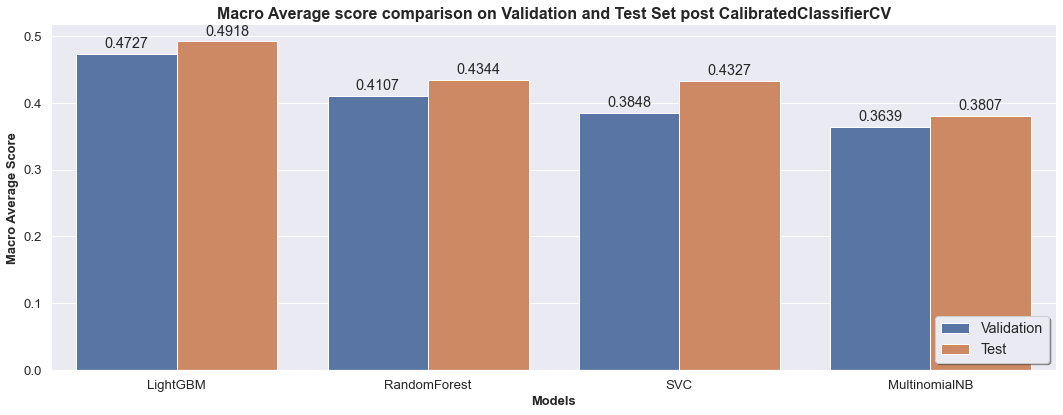

In [161]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(figsize=(15,6))
fig.subplots_adjust(top=0.7)
splot = sns.barplot(x='Method', y="Score", hue="Set", data=plot_data[plot_data['Measure']=="Macro-Avgerage"], ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('Macro Average score comparison on Validation and Test Set post CalibratedClassifierCV', fontsize=16, weight='bold')
axes.set_xlabel('Models', fontsize=13, weight='bold')
axes.set_ylabel('Macro Average Score', fontsize=13, weight='bold')
axes.legend(loc='lower right', shadow=True,fontsize='medium')
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

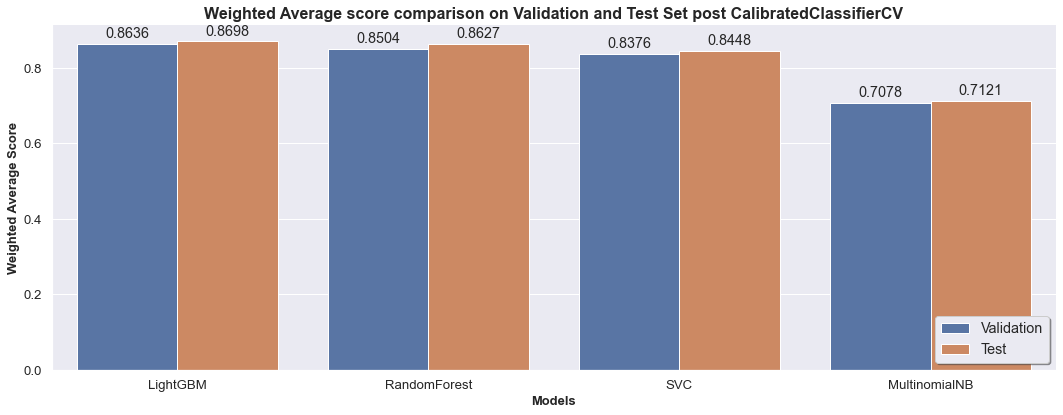

In [162]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(figsize=(15,6))
fig.subplots_adjust(top=0.7)
splot = sns.barplot(x='Method', y="Score", hue="Set", data=plot_data[plot_data['Measure']=="Weighted-Average"], ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('Weighted Average score comparison on Validation and Test Set post CalibratedClassifierCV', fontsize=16, weight='bold')
axes.set_xlabel('Models', fontsize=13, weight='bold')
axes.set_ylabel('Weighted Average Score', fontsize=13, weight='bold')
axes.legend(loc='lower right', shadow=True,fontsize='medium')
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

In [163]:
Model1 = ["LightGBM", "LightGBM", "LightGBM", "LightGBM",
         "RandomForest", "RandomForest", "RandomForest", "RandomForest",
         "SVC", "SVC", "SVC", "SVC",
         "MultinomialNB", "MultinomialNB", "MultinomialNB", "MultinomialNB"]

Set1 = ["Class-0", "Class-1", "Class-2", "Class-3",
       "Class-0", "Class-1", "Class-2", "Class-3", 
       "Class-0", "Class-1", "Class-2", "Class-3",
       "Class-0", "Class-1", "Class-2", "Class-3"]

Measure1 = ["F1-Score", "F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score", "F1-Score"]

Score1 = [e1_valid_cal_perclass[0], e1_valid_cal_perclass[1], e1_valid_cal_perclass[2], e1_valid_cal_perclass[3],
            e2_valid_cal_perclass[0], e2_valid_cal_perclass[1], e2_valid_cal_perclass[2], e2_valid_cal_perclass[3],
            e3_valid_cal_perclass[0], e3_valid_cal_perclass[1], e3_valid_cal_perclass[2], e3_valid_cal_perclass[3], 
            e4_valid_cal_perclass[0], e4_valid_cal_perclass[1], e4_valid_cal_perclass[2], e4_valid_cal_perclass[3]
         ]

In [164]:
plot_data1 = pd.DataFrame([Model1, Set1, Measure1, Score1]).transpose()
plot_data1.columns = ["Method1", "Set1", "Measure1", "Score1"]
plot_data1["Score1"] = plot_data1["Score1"].astype(float)

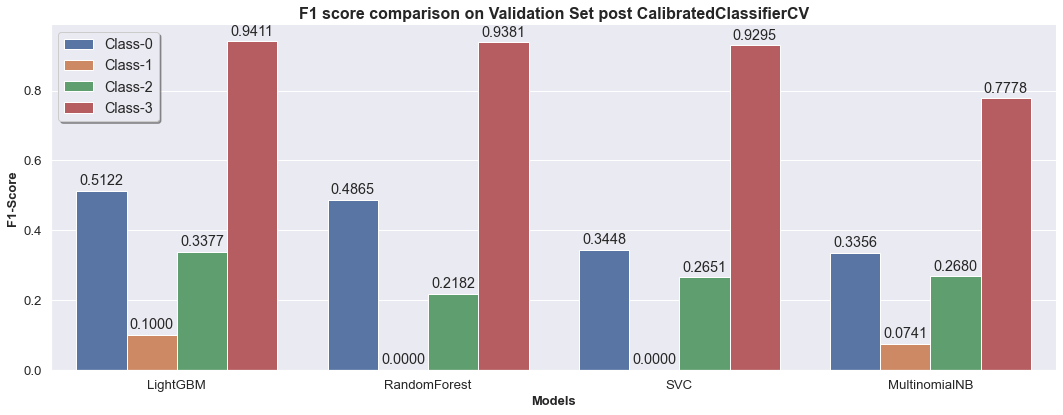

In [165]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(figsize=(15,6))
fig.subplots_adjust(top=0.7)
splot = sns.barplot(x='Method1', y="Score1", hue="Set1", data=plot_data1, ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('F1 score comparison on Validation Set post CalibratedClassifierCV', fontsize=16, weight='bold')
axes.set_xlabel('Models', fontsize=13, weight='bold')
axes.set_ylabel('F1-Score', fontsize=13, weight='bold')
axes.legend(loc='upper left', shadow=True,fontsize='medium')
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

In [166]:
Model2 = ["LightGBM", "LightGBM", "LightGBM", "LightGBM",
         "RandomForest", "RandomForest", "RandomForest", "RandomForest",
         "SVC", "SVC", "SVC", "SVC",
         "MultinomialNB", "MultinomialNB", "MultinomialNB", "MultinomialNB"]

Set2 = ["Class-0", "Class-1", "Class-2", "Class-3",
       "Class-0", "Class-1", "Class-2", "Class-3", 
       "Class-0", "Class-1", "Class-2", "Class-3",
       "Class-0", "Class-1", "Class-2", "Class-3"]

Measure2 = ["F1-Score", "F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score", "F1-Score"]

Score2 = [e1_test_cal_perclass[0], e1_test_cal_perclass[1], e1_test_cal_perclass[2], e1_test_cal_perclass[3],
            e2_test_cal_perclass[0], e2_test_cal_perclass[1], e2_test_cal_perclass[2], e2_test_cal_perclass[3],
            e3_test_cal_perclass[0], e3_test_cal_perclass[1], e3_test_cal_perclass[2], e3_test_cal_perclass[3],
            e4_test_cal_perclass[0], e4_test_cal_perclass[1], e4_test_cal_perclass[2], e4_test_cal_perclass[3]
         ]

In [167]:
plot_data2 = pd.DataFrame([Model2, Set2, Measure2, Score2]).transpose()
plot_data2.columns = ["Method2", "Set2", "Measure2", "Score2"]
plot_data2["Score2"] = plot_data2["Score2"].astype(float)

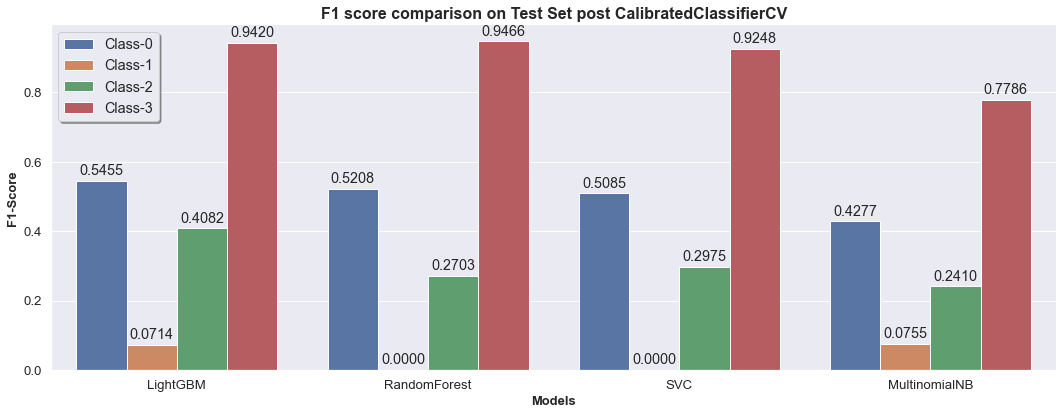

In [168]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(figsize=(15,6))
fig.subplots_adjust(top=0.7)
splot = sns.barplot(x='Method2', y="Score2", hue="Set2", data=plot_data2, ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('F1 score comparison on Test Set post CalibratedClassifierCV', fontsize=16, weight='bold')
axes.set_xlabel('Models', fontsize=13, weight='bold')
axes.set_ylabel('F1-Score', fontsize=13, weight='bold')
axes.legend(loc='upper left', shadow=True,fontsize='medium')
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

**Plot learning curves**

In [169]:
###Function to plot learning curves post model training
def plot_learning_curves(estimator, X_train, y_train, X_val, y_val,
                         suptitle='', title='', xlabel='', ylabel=''):
    """
    Plots learning curves for a given estimator.

    Parameters
    ----------

    estimator : sklearn estimator
    X_train : pd.DataFrame
        training set (features)
    y_train : pd.Series
        training set (response)
    X_val : pd.DataFrame
        validation set (features)
    y_val : pd.Series
        validation set (response)
    suptitle : str
        Chart suptitle
    title: str
        Chart title
    xlabel: str
        Label for the X axis
    ylabel: str
        Label for the y axis

    Returns
    -------

    Plot of learning curves
    """
    

    # create lists to store train and validation scores
    train_score = []
    val_score = []
    # create ten incremental training set sizes
    training_set_sizes = np.linspace(30, len(X_train), 10, dtype='int')

    # for each one of those training set sizes
    for i in training_set_sizes:
        # fit the model only using that many training examples
        estimator.fit(X_train.iloc[0:i, :], y_train.iloc[0:i])
        # calculate the training accuracy only using those training examples
        train_accuracy = f1_score(
                                    y_train.iloc[0:i],
                                    estimator.predict(X_train.iloc[0:i, :]), average='weighted'
                                    )
        # calculate the validation accuracy using the whole validation set
        val_accuracy = f1_score(
                                    y_val,
                                    estimator.predict(X_val), average='weighted'
                                    )
        # store the scores in their respective lists
        train_score.append(train_accuracy)
        val_score.append(val_accuracy)
        
    # plot learning curves
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, val_score, c='steelblue')

    # format the chart to make it look nice
    fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    ax.set_title(title, size=20)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.legend(['training set', 'validation set'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)

    y_formatter = percentages
    ax.yaxis.set_major_formatter(y_formatter)

    x_formatter = numbers
    ax.xaxis.set_major_formatter(x_formatter)

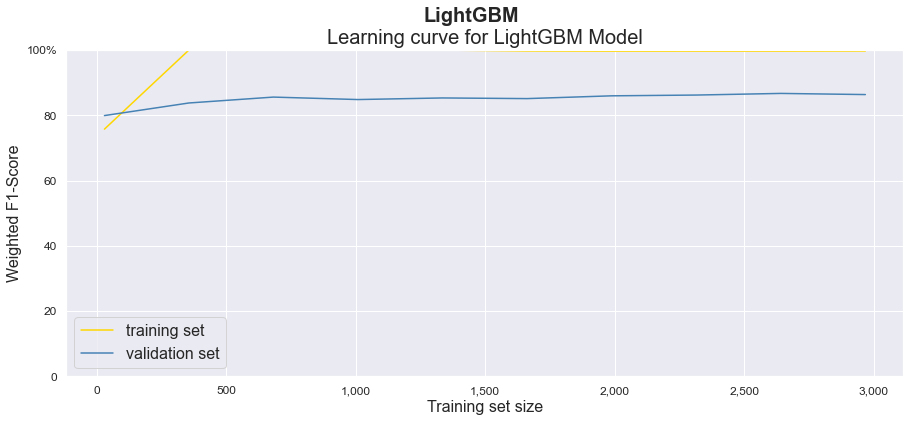

In [170]:
plot_learning_curves(estimator=estimator1,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='LightGBM',
                     title='Learning curve for LightGBM Model',
                     xlabel='Training set size',
                     ylabel='Weighted F1-Score')

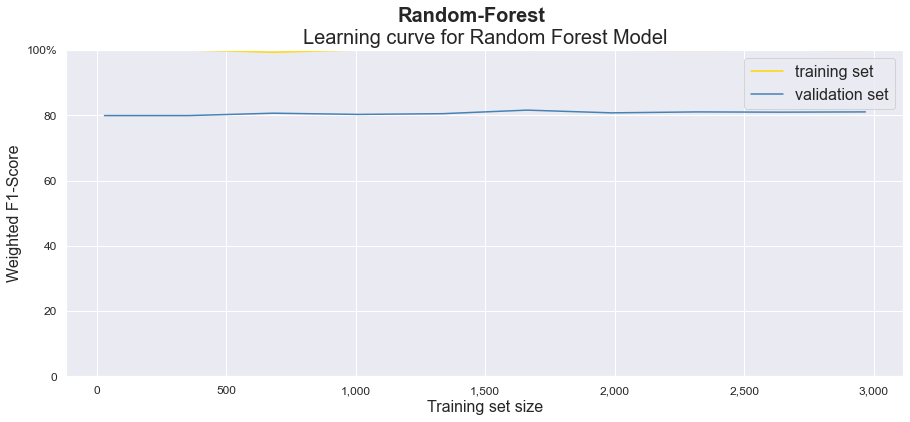

In [171]:
plot_learning_curves(estimator=estimator2,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='Random-Forest',
                     title='Learning curve for Random Forest Model',
                     xlabel='Training set size',
                     ylabel='Weighted F1-Score')

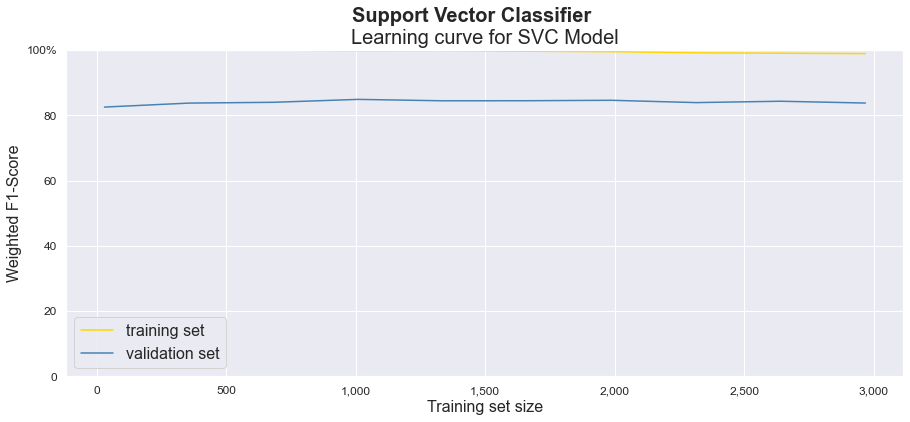

In [172]:
plot_learning_curves(estimator=estimator3,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='Support Vector Classifier',
                     title='Learning curve for SVC Model',
                     xlabel='Training set size',
                     ylabel='Weighted F1-Score')

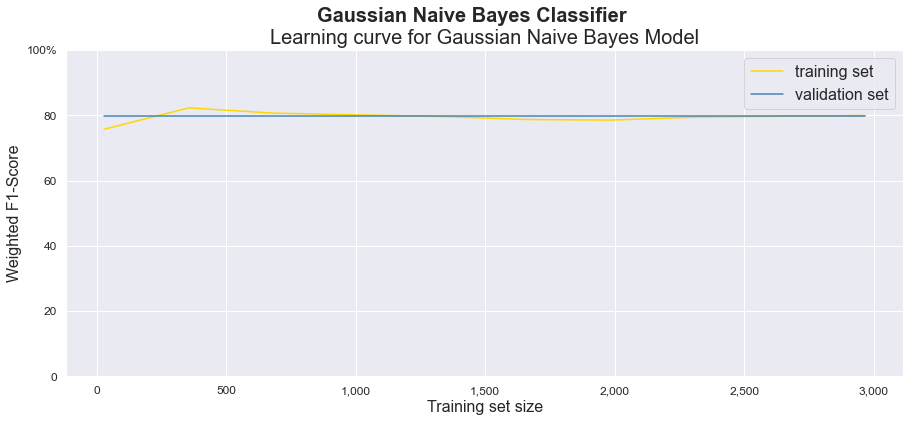

In [173]:
plot_learning_curves(estimator=estimator4,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='Gaussian Naive Bayes Classifier',
                     title='Learning curve for Gaussian Naive Bayes Model',
                     xlabel='Training set size',
                     ylabel='Weighted F1-Score')

**Thank You**